# CS 5394 - Project 1
## Predicting the Global Population in 2122
### Amory Weinzierl, Randolph Rankin, Sofia Murillo, Jennifer Carballo

---
## Background

### Introduction

Problem Background here

### Population Growth Factors

Descriptions of population models

### Chosen Model

Description of our model

## About the Data

### Description of Indicators

#### Life Expectancy

Description

#### Mean Years of Schooling

Description

#### Expected Years of Schooling

Description

#### Gross National Income (GNI) per Capita

Description

### The Human Development Index (HDI)

Description

#### Calculating the HDI

Explanation of calculation

### Data Sources

List of data sources

---
## Preparing the Data

First, we will import the necessary packages needed for our exploration and create a dataframe from our dataset.

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [4]:
read_df = pd.read_csv('aggregate_hdi_indicators_with_population.csv')

read_df.head()

,Entity,Code,Year,Population (historical estimates),"Fertility rate (Complete Gapminder, v12) (2017)","Mortality rate, infant (per 1,000 live births)",Life expectancy,"Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))",Expected Years of Schooling (years),"GNI per capita, PPP (constant 2017 international $)",Actual Human Development Index (UNDP)
0,Afghanistan,AFG,1800,3280000.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1801,3280000.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1802,3280000.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1803,3280000.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1804,3280000.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN


From this preview of the data, we're able to see the various demographic variables provided. For the purposes of our exploration, we'll only need columns from this dataframe related to calculating the HDI.

In [5]:
indicators_raw = read_df.drop(columns = ['Fertility rate (Complete Gapminder, v12) (2017)', 'Mortality rate, infant (per 1,000 live births)', 'Code', 'Actual Human Development Index (UNDP)'])
indicators_raw.head()

,Entity,Year,Population (historical estimates),Life expectancy,"Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))",Expected Years of Schooling (years),"GNI per capita, PPP (constant 2017 international $)"
0,Afghanistan,1800,3280000.0,NaN,NaN,NaN,NaN
1,Afghanistan,1801,3280000.0,NaN,NaN,NaN,NaN
2,Afghanistan,1802,3280000.0,NaN,NaN,NaN,NaN
3,Afghanistan,1803,3280000.0,NaN,NaN,NaN,NaN
4,Afghanistan,1804,3280000.0,NaN,NaN,NaN,NaN


What remains are the four metrics used to calculate the HDI. We can see from the example above, however, that earlier data may only contain a historic population estimate. Because we'll be looking at the HDI as an indicator for population growth, we'll drop any rows for which no HDI component data exists.

In [6]:
indicators_raw.dropna(thresh=4, inplace=True)
indicators_raw.head()

,Entity,Year,Population (historical estimates),Life expectancy,"Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))",Expected Years of Schooling (years),"GNI per capita, PPP (constant 2017 international $)"
70,Afghanistan,1870,4142928.0,NaN,0.01,NaN,NaN
75,Afghanistan,1875,4247357.0,NaN,0.01,NaN,NaN
80,Afghanistan,1880,4354370.0,NaN,0.01,NaN,NaN
85,Afghanistan,1885,4464010.0,NaN,0.01,NaN,NaN
90,Afghanistan,1890,4576341.0,NaN,0.01,NaN,NaN


Now, the rows remaining will contain at least one datapoint required to calculate the HDI. Although an HDI will be unavailable for rows containing any null values, we've chosen to keep all data for any of the indicators. This will be helpful later in our exploration as we attempt to project a future HDI.

---
## Precursory Calculations

Our dataset is currently segmented by country. However, we're more interested in this exploration to see how these indicators have changed globally. For that reason, we wish to use this country-level data to find global averages for each indicator. We'll achieve this by taking a weighted mean for each indicator for each year.

### Weighting the Indicators

For each datapoint, we'll assign a weight to its value. That weight is assigned as follows:

$\gamma_{I, \alpha, Y} = \dfrac{P_{\alpha, Y}}{\sum{P_{I, Y}}}$

*Where $\gamma_{I, \alpha, Y}$—or the weight of a given indicator, $I$, for some country $\alpha$ on year $Y$—can be calculated as the ratio between $P_{\alpha, Y}$—the population of $\alpha$ on year $Y$—and the sum of all values $P_{I, Y}$, or the total population of all countries on year $Y$ with available data for indicator $I$.*

By determining the indicator weight for each data point, we're able to calculate an indicator's mean, weighted by a country's population, on a particular year $M_{I,Y}$, as the sum of all relevant values of $\gamma_{I, \alpha, Y}$.

First, let's reformat our columns. Then, we'll find each data point's component of its indicator's weighted average.

In [7]:
# Rename the columns for readability

col_dict = {
    'Entity': 'country',
    'Year': 'year',
    'Population (historical estimates)': 'population',
    'Life expectancy': 'life_expectancy',
    'Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))': 'mean_yos',
    'Expected Years of Schooling (years)': 'expected_yos',
    'GNI per capita, PPP (constant 2017 international $)': 'gni_per_capita'
}

indicators_raw.rename(columns=col_dict, inplace=True)

In [8]:
# Introduce a function to calculate a column with weighted average components

def calculated_weighted_avg_component(df, indicator_col):
    
    # Locate rows in the dataframe with non-null indicator values and find the total population by year
    indicator_pop_total = df.population.loc[pd.notna(indicator_col)].groupby(df.year).sum().rename('indicator_pop_total')
    
    # Join the previous row to the dataframe
    df_manip = df.join(indicator_pop_total, on='year', how='outer')
    
    # Calculate weights for each data point and find their component of the indicator's weighted average 
    indicator_weight = df_manip.population / df_manip.indicator_pop_total
    weighted_indicator_component = indicator_weight * indicator_col
    
    return weighted_indicator_component

In [9]:
# Use the previously defined function to calculated the components of the weighted averages

weight_params = [
    ('le_weighted_component', indicators_raw.life_expectancy),
    ('myos_weighted_component', indicators_raw.mean_yos),
    ('eyos_weighted_component', indicators_raw.expected_yos),
    ('gnipc_weighted_component', indicators_raw.gni_per_capita)
]

for col_name, indicator_col in weight_params:
    indicators_raw[col_name] = calculated_weighted_avg_component(indicators_raw, indicator_col)
    
indicators_raw.loc[indicators_raw.year == 2000].head()

,country,year,population,life_expectancy,mean_yos,expected_yos,gni_per_capita,le_weighted_component,myos_weighted_component,eyos_weighted_component,gnipc_weighted_component
200,Afghanistan,2000,20779957.0,55.841,2.2,5.9,NaN,0.188879,0.007702,0.020183,NaN
422,Albania,2000,3129246.0,73.955,8.8,10.6,NaN,0.037670,0.004639,0.005460,NaN
644,Algeria,2000,31042238.0,70.640,5.9,10.9,8391.639382,0.356935,0.030857,0.055701,49.104221
731,American Samoa,2000,57816.0,71.184,NaN,NaN,NaN,0.000670,NaN,NaN,NaN
953,Andorra,2000,65390.0,78.857,6.7,10.8,NaN,0.000839,0.000074,0.000116,NaN


### Finding Global Indicator Averages

Now that we've calculated the components of each indicator's weighted average, we can group our dataframe by year to find global averages. This will allow us to explore global trends over time.

In [10]:
# Create a dataframe for global indicators by grouping and aggregating by sum

global_indicators = indicators_raw[['year', 'population', 'le_weighted_component', 'myos_weighted_component', 'eyos_weighted_component', 'gnipc_weighted_component']].groupby('year').apply(lambda x: x.sum(min_count=1))
# (The lambda is a workaround for sum aggregration in pandas treating np.nan as 0.0)

# Format new dataframe by renaming columns and dropping the extraneous year column

global_indicators.rename(columns={'le_weighted_component': 'life_expectancy', 'myos_weighted_component': 'mean_yos', 'eyos_weighted_component': 'expected_yos', 'gnipc_weighted_component': 'gni_per_capita'}, inplace=True)
global_indicators.drop(['year'], axis=1, inplace=True)

global_indicators.tail()

,population,life_expectancy,mean_yos,expected_yos,gni_per_capita
year,,,,,
2016,7.464012e+09,72.223146,7.982917,13.188746,15780.970942
2017,7.547849e+09,72.426848,7.998527,13.193718,16215.177712
2018,7.631081e+09,72.612756,NaN,NaN,16586.907293
2019,7.713458e+09,72.783500,NaN,NaN,16421.030285
2020,4.637912e+09,NaN,NaN,NaN,11603.307151


In [11]:
# With this output, we verify that our data for 2020 is incomplete, so we can drop this row.

global_indicators.drop(2020, inplace=True)

---
## Projecting HDI Indicators

Now that our dataframe has been condensed into global averages for each indicator, we wish to project these indicators into the future. This will allow us to calculate a theoretical global HDI.

### Visualizing Current Indicators

Due to the nature of our dataset, we have the most complete data for recent decades. By visualizing each indicator, we can get an idea for what range of years provide us with the highest resolution data for each indicator.

In [12]:
# Global plot formatting constants
PLOT_SIZE = (20, 10)
FONT_SIZE = 15

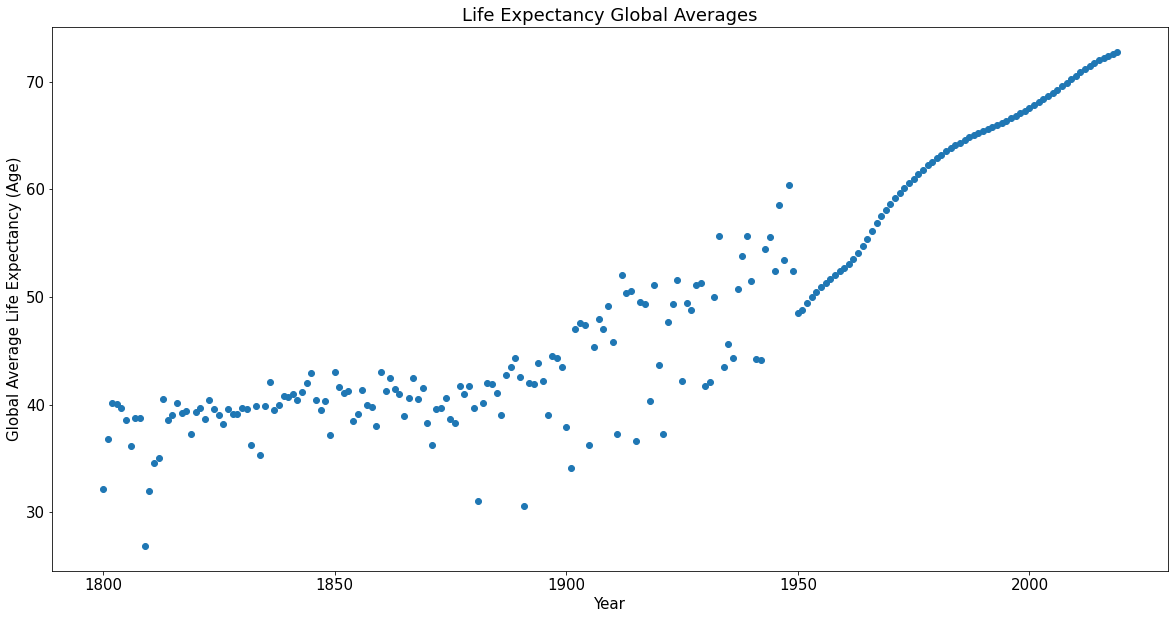

In [13]:
# Visualizing life exepectancy
plt.figure(figsize=PLOT_SIZE)
plt.rc('font', size=FONT_SIZE) 
plt.scatter(global_indicators.index, global_indicators.life_expectancy)
plt.title('Life Expectancy Global Averages')
plt.xlabel('Year')
plt.ylabel('Global Average Life Expectancy (Age)')
plt.show()

From this visualization, we're able to see that our highest resolution data of life expectancy exists from about 1950 onward.

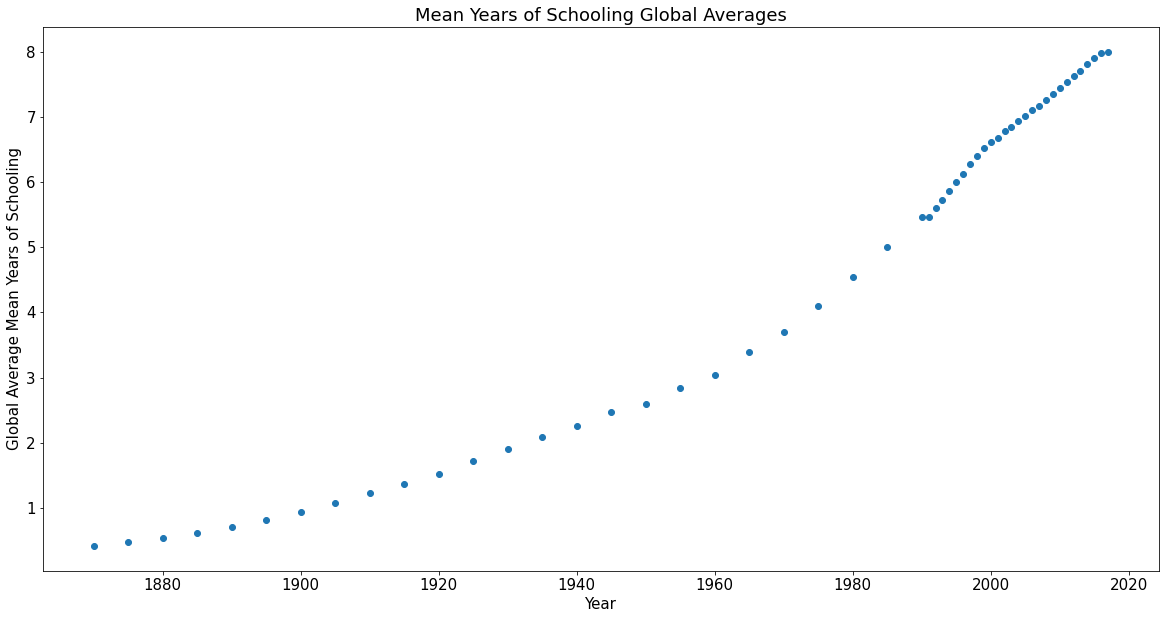

In [14]:
# Visualizing mean years of schooling
plt.figure(figsize=PLOT_SIZE)
plt.rc('font', size=FONT_SIZE) 
plt.scatter(global_indicators.index, global_indicators.mean_yos)
plt.title('Mean Years of Schooling Global Averages')
plt.xlabel('Year')
plt.ylabel('Global Average Mean Years of Schooling')
plt.show()

Our data for this indicator is most complete for the previous three decades, although remaining data still gives us a good idea of current trends.

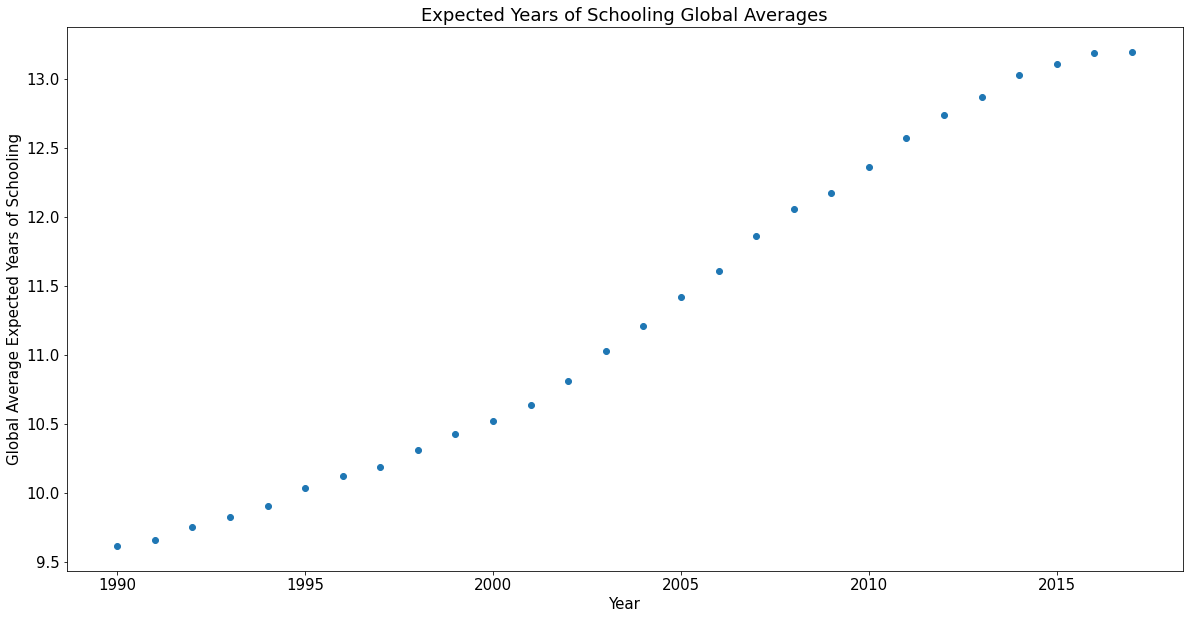

In [15]:
# Visualizing expected years of schooling
plt.figure(figsize=PLOT_SIZE)
plt.rc('font', size=FONT_SIZE) 
plt.scatter(global_indicators.index, global_indicators.expected_yos)
plt.title('Expected Years of Schooling Global Averages')
plt.xlabel('Year')
plt.ylabel('Global Average Expected Years of Schooling')
plt.show()

The data available for this metric is only available for the past three decades and appears to be of sufficient resolution.

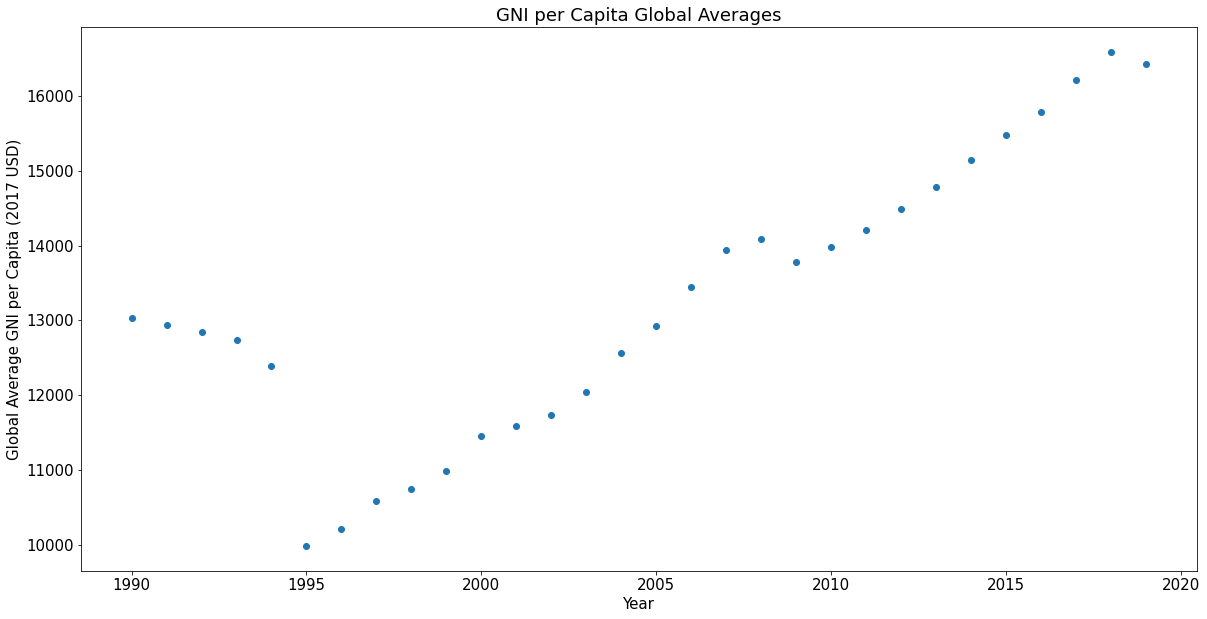

In [16]:
# Visualizing GNI per capita
plt.figure(figsize=PLOT_SIZE)
plt.rc('font', size=FONT_SIZE) 
plt.scatter(global_indicators.index, global_indicators.gni_per_capita)
plt.title('GNI per Capita Global Averages')
plt.xlabel('Year')
plt.ylabel('Global Average GNI per Capita (2017 USD)')
plt.show()

Limited countries have available data prior to 1995, thus our best idea of current GNI per capita trends are between 1995 and now.

### Determining Trends and Projecting Future Values

Now, we'll fit trendlines to our highest resolution data. Using this trendline, we'll infer the growth of these four indicators based on current trends.

In [17]:
# Define a function to project future values based on a line of best fit

def project_indicator(df, indicator_col_name, min_year=None, log=False, project_until=2122):
    # Take a subset of the data if necessary
    df_manip = df.loc[min_year:2017][[indicator_col_name]].dropna() if min_year else df.loc[:2017][[indicator_col_name]].dropna()
    
    # Find the fit coeffeicient and constant
    if log:
        m, b = np.polyfit(np.log(df_manip.index), df_manip[indicator_col_name], deg=1)
    else:
        m, b = np.polyfit(df_manip.index, df_manip[indicator_col_name], deg=1)
    
    # Create and fill a dataframe column for future years
    max_indicator_year = df[indicator_col_name].dropna().index.max()
    future_data = pd.DataFrame({'year': range(max_indicator_year+1, project_until+1)}).set_index('year')
    future_data[indicator_col_name] = m * np.log(future_data.index) + b if log else m * future_data.index + b
        
    # Return the combined historic and projected data as one column
    return pd.concat([df[[indicator_col_name]], future_data])    

In [18]:
# Calculate projected values and combine into a new dataframe

proj_le_col = project_indicator(global_indicators, 'life_expectancy', min_year=1900, log=True)
proj_myos_col = project_indicator(global_indicators, 'mean_yos', min_year=1990, log=True)
proj_eyos_col = project_indicator(global_indicators, 'expected_yos', log=True)
proj_gnipc_col = project_indicator(global_indicators, 'gni_per_capita', min_year=1995, log=True)


projected_indicators = pd.merge(pd.merge(proj_le_col, proj_myos_col, on='year'), pd.merge(proj_eyos_col, proj_gnipc_col, on='year'), on='year')

projected_indicators.tail()

,life_expectancy,mean_yos,expected_yos,gni_per_capita
year,,,,
2118,96.568852,17.549326,27.973355,43166.605287
2119,96.812482,17.640356,28.114986,43428.258007
2120,97.055997,17.731342,28.256549,43689.787276
2121,97.299398,17.822286,28.398046,43951.193212
2122,97.542683,17.913187,28.539477,44212.475930


So, following current trends, these are the values we would expect for these indicators in 2122.

### Calculating Theoretical Adjusted HDI

Covered earlier in our background of the Human Development Index, the UN determines certain benchmarks used to calculate each component of an HDI as an index between 0 and 1. Although we can't be certain how these benchmark values may be calculated in the future, we can use our projections of HDI indicators to get a better idea of what they might be.

To accomplish this, we'll take a look at the difference between today's global HDI indicator averages and the goalpost value currently established by the UN. We'll apply that same delta value to our projected indicator values in 2122 to approxomate a theoretical goalpost value for each indicator.

For the minimum benchmark values, we'll use the UN's current minimum benchmarks as we'll want our indexes to adequately measure today's global development against our future predictions.

In [19]:
# Define current indicator benchmarks

CURRENT_LE_MINIMUM, CURRENT_LE_GOALPOST = 20, 85
CURRENT_MYOS_MINIMUM, CURRENT_MYOS_GOALPOST = 0, 15
CURRENT_EYOS_MINIMUM, CURRENT_EYOS_GOALPOST = 0, 18
CURRENT_GNIPC_MINIMUM, CURRENT_GNIPC_GOALPOST = 100, 75000

# Determine goalpost deltas

le_goalpost_delta = CURRENT_LE_GOALPOST - global_indicators.life_expectancy[global_indicators.life_expectancy.dropna().index.max()]
myos_goalpost_delta = CURRENT_MYOS_GOALPOST - global_indicators.mean_yos[global_indicators.mean_yos.dropna().index.max()]
eyos_goalpost_delta = CURRENT_EYOS_GOALPOST - global_indicators.expected_yos[global_indicators.expected_yos.dropna().index.max()]
gnipc_goalpost_delta = CURRENT_GNIPC_GOALPOST - global_indicators.gni_per_capita[global_indicators.gni_per_capita.dropna().index.max()]

# Estimate future goalposts based on current deltas

theoretical_le_goalpost = (projected_indicators.life_expectancy[2122] + le_goalpost_delta).round()
theoretical_myos_goalpost = (projected_indicators.mean_yos[2122] + myos_goalpost_delta).round()
theoretical_eyos_goalpost = (projected_indicators.expected_yos[2122] + eyos_goalpost_delta).round()
theoretical_gnipc_goalpost = (projected_indicators.gni_per_capita[2122] + gnipc_goalpost_delta).round()

# Set theoretical minimums to current minimum

theoretical_le_minimum, theoretical_myos_minimum, theoretical_eyos_minimum, theoretical_gnipc_minimum = \
    CURRENT_LE_MINIMUM, CURRENT_MYOS_MINIMUM, CURRENT_EYOS_MINIMUM, CURRENT_GNIPC_MINIMUM

print(f'Life Expectancy Benchmarks: from {theoretical_le_minimum} to {theoretical_le_goalpost}')
print(f'Mean Years of Schooling Benchmarks: from {theoretical_myos_minimum} to {theoretical_myos_goalpost}')
print(f'Expected Years of Schooling Benchmarks: from {theoretical_eyos_minimum} to {theoretical_eyos_goalpost}')
print(f'GNI per Capita Benchmarks: from {theoretical_gnipc_minimum} to {theoretical_gnipc_goalpost}')

Life Expectancy Benchmarks: from 20 to 110.0
Mean Years of Schooling Benchmarks: from 0 to 25.0
Expected Years of Schooling Benchmarks: from 0 to 33.0
GNI per Capita Benchmarks: from 100 to 102791.0


Now that we have our theoretical benchmarks, we can use our projected indicator data to calculate a theoretical HDI adjusted for our predictions.

In [20]:
# Calculate index values for each component of the HDI
le_index = (projected_indicators.life_expectancy - theoretical_le_minimum) / (theoretical_le_goalpost - theoretical_le_minimum)
myos_index = (projected_indicators.mean_yos - theoretical_myos_minimum) / (theoretical_myos_goalpost - theoretical_myos_minimum)
eyos_index = (projected_indicators.expected_yos - theoretical_eyos_minimum) / (theoretical_eyos_goalpost - theoretical_eyos_minimum)
edu_index = (myos_index + eyos_index) / 2
gnipc_index = (np.log(projected_indicators.gni_per_capita) - np.log(theoretical_gnipc_minimum)) / (np.log(theoretical_gnipc_goalpost) - np.log(theoretical_gnipc_minimum))

# Use components to calculate an adjusted HDI column for our projected indicator values

projected_indicators['theoretical_hdi'] = (le_index * edu_index * gnipc_index) ** (1/3)

projected_indicators.dropna().tail()


,life_expectancy,mean_yos,expected_yos,gni_per_capita,theoretical_hdi
year,,,,,
2118,96.568852,17.549326,27.973355,43166.605287,0.832383
2119,96.812482,17.640356,28.114986,43428.258007,0.834962
2120,97.055997,17.731342,28.256549,43689.787276,0.837535
2121,97.299398,17.822286,28.398046,43951.193212,0.840103
2122,97.542683,17.913187,28.539477,44212.475930,0.842666


---
## Exploring the Relationship Between HDI and Population Growth

From our background discussion, we learned how communities experience a decline in population growth as they become more developed. Next, with our theoretical global HDI projection, we'll attempt to establish a relationship between human development and population rates that we can use to project the global population.

First, let's calculate a column for population growth alongside our global indicator data.

In [21]:
global_indicators['pop_growth_rate'] = global_indicators.population.pct_change()
global_indicators[['population', 'pop_growth_rate']].tail()

,population,pop_growth_rate
year,,
2015,7.379787e+09,0.011584
2016,7.464012e+09,0.011413
2017,7.547849e+09,0.011232
2018,7.631081e+09,0.011027
2019,7.713458e+09,0.010795


Next, let's visualize the relationship between our calculated growth rate and our theoretical HDI values.

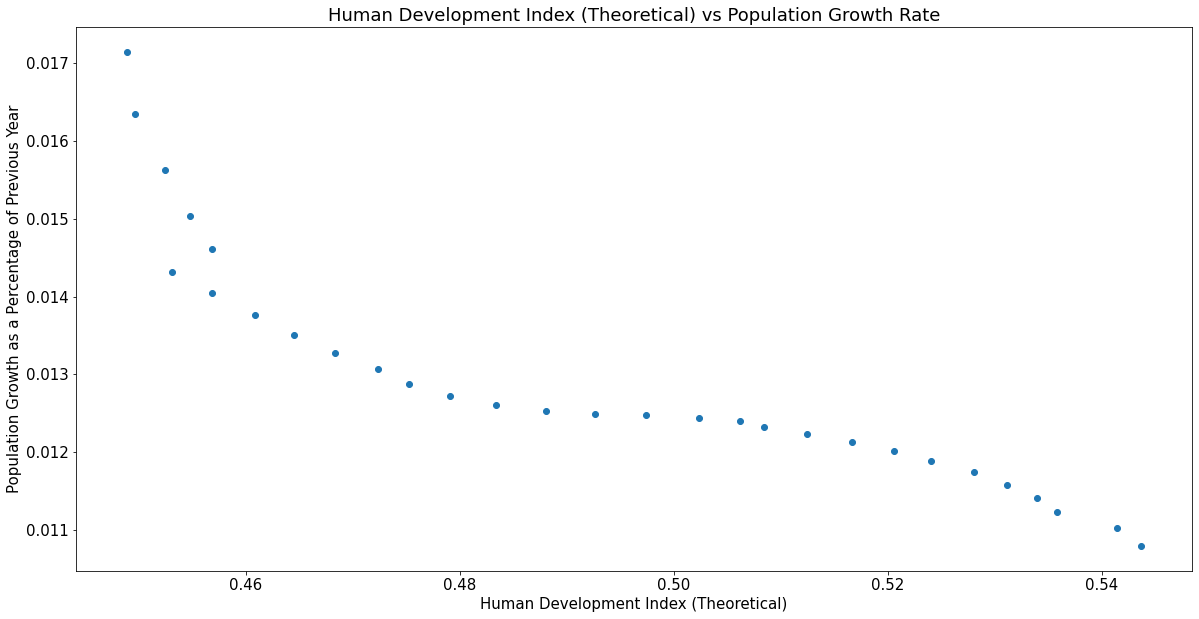

In [22]:
# Join theoretical HDI and growth rate into a new dataframe
hdi_vs_pop_growth = projected_indicators[['theoretical_hdi']].dropna().join(global_indicators.pop_growth_rate, how='inner')

# Plot the two sets of data
plt.figure(figsize=PLOT_SIZE)
plt.rc('font', size=FONT_SIZE) 
plt.scatter(hdi_vs_pop_growth.theoretical_hdi, hdi_vs_pop_growth.pop_growth_rate)
plt.title('Human Development Index (Theoretical) vs Population Growth Rate')
plt.xlabel('Human Development Index (Theoretical)')
plt.ylabel('Population Growth as a Percentage of Previous Year')
plt.show()

From this plot, it appears that a negative correlation exists between HDI and population growth. As the global population becomes more developed, we experience a slowdown of population growth.

By fitting a trendline to this relationship, we'll be able to calculate population growth as a function of HDI.

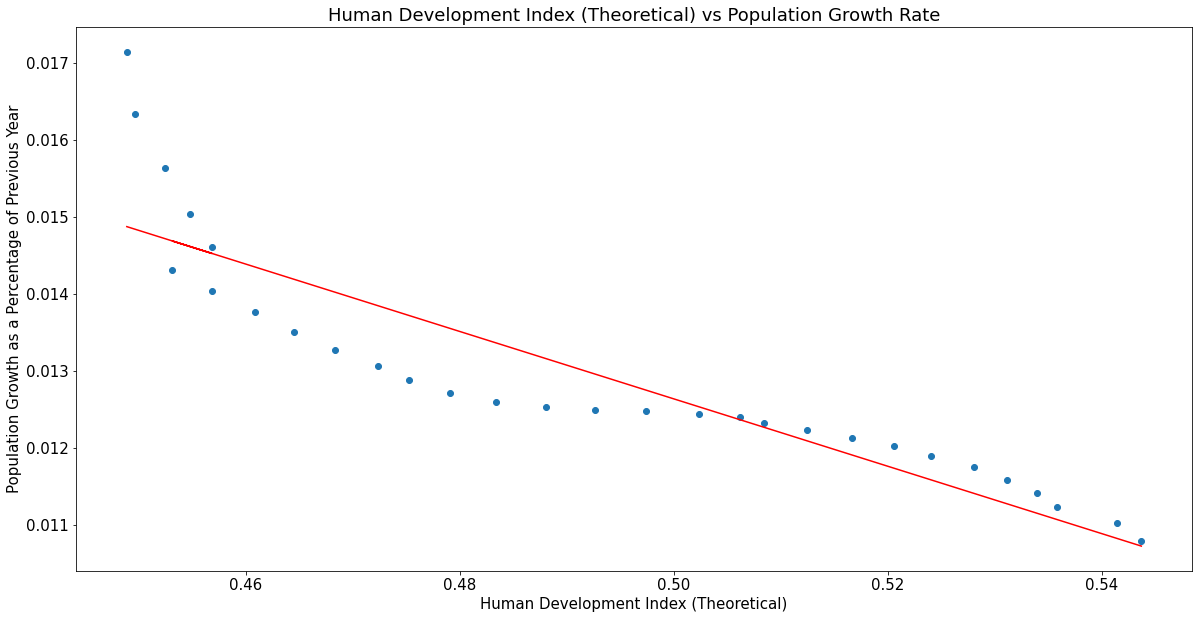

In [23]:
# Determine coeffeicient & constant for our linear regression
reg_m, reg_b = np.polyfit(hdi_vs_pop_growth.theoretical_hdi, hdi_vs_pop_growth.pop_growth_rate, deg=1)

# Plot the trendline over our previous plot
plt.figure(figsize=PLOT_SIZE)
plt.rc('font', size=FONT_SIZE) 
plt.scatter(hdi_vs_pop_growth.theoretical_hdi, hdi_vs_pop_growth.pop_growth_rate)
plt.plot(hdi_vs_pop_growth.theoretical_hdi, reg_m * hdi_vs_pop_growth.theoretical_hdi + reg_b, color='red')
plt.title('Human Development Index (Theoretical) vs Population Growth Rate')
plt.xlabel('Human Development Index (Theoretical)')
plt.ylabel('Population Growth as a Percentage of Previous Year')
plt.show()

---
## Projecting the Global Population

Now, we have all of the components needed to complete our model. Using our projected theoretical HDI to measure global development, we'll use the relationship between HDI and population growth rate to determine how the population will change each year.

In [24]:
# Forcast population growth rate based on previously calculated trendline

projected_pop_rate = (projected_indicators.theoretical_hdi.dropna() * reg_m + reg_b).rename('pop_growth_rate')
projected_pop_rate.tail()

year
2118   -0.001908
2119   -0.002021
2120   -0.002133
2121   -0.002246
2122   -0.002358
Name: pop_growth_rate, dtype: float64

Finally, we'll use these growth rates to predict the global population based on our most recent population figure.

In [25]:
# Define a new dataframe to hold the population
max_pop_year = global_indicators.population.dropna().index.max()
population_projection = pd.DataFrame({'year': range(max_pop_year, 2122+1)}).set_index('year').join(global_indicators.population).join(projected_pop_rate)

# Iteratively determine the unknown population based on projected population growth rate and previous year's population
for year in population_projection.index:
    if pd.isna(population_projection.loc[year].population):
        population_projection.loc[year].population = population_projection.loc[year-1].population * (1 + population_projection.loc[year].pop_growth_rate)
        
population_projection

,population,pop_growth_rate
year,,
2019,7.713458e+09,0.010726
2020,7.795943e+09,0.010694
2021,7.878129e+09,0.010542
2022,7.959995e+09,0.010392
2023,8.041518e+09,0.010242
...,...,...
2118,1.154990e+10,-0.001908
2119,1.152656e+10,-0.002021
2120,1.150197e+10,-0.002133


...And there we go! Based on our model, we predict that the global population in 2122 will be about **11.45 billion**!

## Analysis and Conclusion

As much as I would love to write this... I have to go to sleep. Lol.